In [1]:
import random
import pandas as pd

random.seed(1729)

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('waitlist_kidney_brazil_prepared_sensitive.csv', encoding='iso-8859-1')
df.head()

,date_registered,age_registered,dialysis_session_count,sex,race,underlying_disease,diabetes,chagas,blood_type,transfusion_count,...,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,Branca,other,True,False,A,0,...,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,Branca,diabetes,False,False,A,0,...,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,Branca,hypertension,True,False,O,0,...,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,Branca,diabetes,False,False,O,0,...,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,Parda,hypertension,True,False,A,0,...,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


In [4]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df[df['event'] == 'transplanted'].copy()
    df_clean.drop(columns=['event'], inplace=True)
    df_clean['date_registered'] = \
        pd.to_datetime(df['date_registered']).astype(int) / (1e9 * 3600 * 24)
    df_clean['date_transplanted'] = \
        pd.to_datetime(df['date_registered']) + pd.to_timedelta(df_clean['days_waiting'], 'days')
    return df_clean


def onehot_encode(df: pd.DataFrame) -> pd.DataFrame:
    df_onehot = pd.get_dummies(
        df,
        columns=list(set([
            'sex',
            'race',
            'underlying_disease',
            'blood_type',
            'dr_00',
            'b_00',
            'a_00'
        ]) & set(df.columns)),
        drop_first=True
    )
    df_onehot['race'] = df['race']
    df_onehot['sex'] = df['sex']
    return df_onehot


def train_test_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df = df.copy()
    N = df.shape[0]
    N_train = N * 80 // 100
    df.sort_values(by='date_registered', inplace=True, ignore_index=True)
    return df.iloc[:N_train], df[N_train:]


from fairlearn.preprocessing import CorrelationRemover


def remove_correlation(df: pd.DataFrame, *, correlation_remover = None) -> pd.DataFrame:
    sensitive_features = ['sex_M', 'race_Branca', 'race_Parda', 'race_Negra']
    if correlation_remover is None:
        correlation_remover = CorrelationRemover(sensitive_feature_ids=sensitive_features)
    meta = ['race', 'sex', 'date_registered', 'date_transplanted']
    mesa = df.drop(columns=meta) # Vide Cheal, Joe. "What is the opposite of meta?." ANLP Acuity Vol 2 (2011).
    data = correlation_remover.fit_transform(mesa)
    return pd.concat(
        [
            pd.DataFrame(data, index=mesa.index, columns=[col for col in mesa.columns if not col in sensitive_features]),
            df[meta],
            # df[sensitive_features] # Não faz sentido adicionar de volta, né?
        ],
        axis=1
    ), correlation_remover


def augment_df(df: pd.DataFrame) -> pd.DataFrame:
    return df
    sensitive_features = ['sex', 'race']
    groups = df.groupby(sensitive_features)
    big = groups.count().max().max()
    return pd.concat(
        [
            pd.concat([data, data.sample(big - data.shape[0], replace=True, random_state=1729)])
            for _, data in groups
        ]
    )


df_people = onehot_encode(clean(df))
df_people_train, df_people_test = train_test_split(df_people)
df_people_train_uncorrelated, remover = remove_correlation(augment_df(df_people_train))
df_people_test_uncorrelated, _ = remove_correlation(df_people_test, correlation_remover=remover)
df_people_train_uncorrelated.head()

,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,...,a_00_homozygous,b_00_homozygous,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,race,sex,date_registered,date_transplanted
0,-92.582200,-58.700518,-2.698233,0.0,-1.301101,-0.786908,-0.324948,-23.324170,-11.903592,-62.610706,...,-0.356975,-0.163960,-0.647694,-0.918502,-1.050267,-0.081770,Amarela,M,10959.0,2004-01-21
1,-0.042631,-5.766944,0.325496,0.0,-0.337311,-0.492080,-0.088624,-12.042722,-4.172172,10.890023,...,-0.076394,-0.040446,-0.188164,-0.139036,0.680715,-0.028020,Branca,F,10962.0,2012-06-20
2,-6.042631,-4.766944,0.325496,0.0,0.662689,-0.492080,-0.088624,-12.042722,23.827828,13.890023,...,-0.076394,-0.040446,0.811836,-0.139036,-0.319285,-0.028020,Branca,F,10962.0,2004-07-04
3,-2.712931,-12.583659,0.222175,0.0,-0.330989,0.016731,-0.101278,-3.689081,14.638685,8.354488,...,-0.095291,-0.050848,-0.192500,0.767132,-0.327444,-0.025014,Branca,M,10962.0,2006-06-19
4,7.957369,-11.766944,0.325496,0.0,0.662689,0.507920,-0.088624,52.957278,-4.172172,48.890023,...,-0.076394,-0.040446,-0.188164,0.860964,-0.319285,-0.028020,Branca,F,10962.0,2009-11-17


In [5]:
def sample_pairs(people: pd.DataFrame, n) -> pd.DataFrame:
    pairs = set()
    while len(pairs) < n:
        a = random.randint(1, people.shape[0] - 1)
        b = random.randint(max(0, a - 1000), a-1)
        pairs.add((a, b))
    a = [i for (i, _) in pairs]
    b = [i for (_, i) in pairs]

    df_a = people.iloc[a]
    df_a.columns = df_a.columns + '_a'
    df_b = people.iloc[b]
    df_b.columns = df_b.columns + '_b'

    df_a.index = df_b.index = range(len(pairs))

    df_pairs = pd.concat((df_a, df_b), axis=1)
    df_pairs['transplanted_first'] = \
        df_pairs['date_transplanted_a'] < df_pairs['date_transplanted_b']
    return df_pairs


df_pairs = sample_pairs(df_people_train, 200000)
df_pairs.head()

,date_registered_a,age_registered_a,dialysis_session_count_a,diabetes_a,chagas_a,transfusion_count_a,gestation_a,prior_transplant_a,c_pra_a,hla_a1_a,...,sex_M_b,a_00_homozygous_b,b_00_homozygous_b,underlying_disease_glomerulonephritis_b,underlying_disease_hypertension_b,underlying_disease_other_b,underlying_disease_pyelonephritis_b,race_b,sex_b,transplanted_first
0,13629.0,28,60.0,True,False,0,False,True,19,3,...,True,False,False,False,False,True,False,Branca,M,True
1,14463.0,28,10.0,True,False,0,True,False,0,2,...,True,False,False,False,False,False,False,Branca,M,False
2,15614.0,32,38.0,True,False,1,True,False,37,1,...,True,False,False,False,False,True,False,Branca,M,False
3,13063.0,35,11.0,True,False,0,False,False,0,24,...,False,True,False,True,False,False,False,Branca,F,False
4,11248.0,60,5.0,True,False,0,False,False,0,0,...,True,False,False,False,False,True,False,Branca,M,False


In [6]:
df_pairs.to_csv('waitlist_kidney_sensitive_pairs.csv',index=False)

In [7]:
df_pairs_uncorrelated = sample_pairs(df_people_train_uncorrelated, 200000)
df_pairs_uncorrelated.head()
df_pairs.to_csv('waitlist_kidney_uncorrelated_pairs.csv',index=False)

In [7]:
def X_y_meta_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    target = 'transplanted_first'
    _meta = ['days_waiting_a', 'days_waiting_b', 'date_transplanted_a', 'date_transplanted_b', 'sex_a', 'sex_b', 'race_a', 'race_b']
    return df.drop(columns=[target, *_meta]), df[target], df[_meta]


X, y, meta = X_y_meta_split(df_pairs)
Xu, yu, metau = X_y_meta_split(df_pairs_uncorrelated)

In [8]:
from aif360.sklearn.preprocessing import Reweighing

protected_columns = ['sex_a', 'sex_b', 'race_a', 'race_b']

X_p = pd.concat([X, meta[protected_columns]], axis=1)
Xu_p = pd.concat([Xu, metau[protected_columns]], axis=1)

def reweigh_pairs(X: pd.DataFrame, y: pd.DataFrame) -> [float]:
    return Reweighing(protected_columns).fit_transform(X.set_index(protected_columns), y)[1]

Wx = reweigh_pairs(X_p,y)

pip install 'aif360[FairAdapt]'
pip install 'aif360[LFR]'


In [9]:
from sklearn.ensemble import RandomForestClassifier

def make_classifier():
    return RandomForestClassifier(
        n_estimators=200,
        max_features='log2',
        random_state=1729,
        n_jobs=-1
    )

def train_classifier(X, y):
    classifier = make_classifier()
    classifier.fit(X, y)
    return classifier

classifier = train_classifier(X, y)
df_pairs_test = sample_pairs(df_people_test, 200000)
X_test, y_test, meta_test = X_y_meta_split(df_pairs_test)
y_train_pred = classifier.predict_proba(X)[:, 1]
y_pred = classifier.predict_proba(X_test)[:, 1]
del classifier

classifier = train_classifier(Xu, yu)
df_pairs_test_uncorrelated = sample_pairs(df_people_test_uncorrelated, 200000)
Xu_test, yu_test, metau_test = X_y_meta_split(df_pairs_test_uncorrelated)
yu_pred = classifier.predict_proba(Xu_test)[:, 1]
del classifier

classifier = make_classifier()
classifier.fit(X,y,Wx)
yw_pred = classifier.predict_proba(X_test)[:, 1]
del classifier


In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f'baseline - acurácia: {accuracy_score(y_test, y_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, y_pred > 0.5)}')
print(f'correlation remover - acurácia: {accuracy_score(yu_test, yu_pred > 0.5)}, ROC AUC:{roc_auc_score(yu_test, yu_pred > 0.5)}')
print(f'reweighted - acurácia: {accuracy_score(y_test, yw_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, yw_pred > 0.5)}')

baseline - acurácia: 0.604725, ROC AUC:0.537911556834413
correlation remover - acurácia: 0.618035, ROC AUC:0.5302455645278846
reweighted - acurácia: 0.605715, ROC AUC:0.5404005409326282


In [11]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction
from fairlearn.reductions import EqualizedOdds

inpro = ExponentiatedGradientReduction(protected_columns, make_classifier(), EqualizedOdds(), eps=0.1)
inpro.fit(X_p, y)

pip install 'aif360[AdversarialDebiasing]'
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:212: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
/home/guigb/workspace/unicamp/ia2/mo810-kidne

ExponentiatedGradientReduction(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x7faa21b25b50>,
                               eps=0.1,
                               estimator=RandomForestClassifier(max_features='log2',
                                                                n_estimators=200,
                                                                n_jobs=-1,
                                                                random_state=1729),
                               prot_attr=['sex_a', 'sex_b', 'race_a', 'race_b'])

In [12]:
yf_pred = inpro.predict_proba(X_p)[:, 1]

In [13]:
print(f'exponentiated gradient - acurácia: {accuracy_score(y_test, yf_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, yf_pred > 0.5)}')

exponentiated gradient - acurácia: 0.521595, ROC AUC:0.4983712032756077


In [14]:
from aif360.sklearn.inprocessing import GridSearchReduction
inpro2 = GridSearchReduction(protected_columns, make_classifier(), EqualizedOdds())
inpro2.fit(X_p, y)

/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:212: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pos_basis[i] = 0 + zero_vec
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:213: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.neg_basis[i] = 0 + zero_vec
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packag

GridSearchReduction(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x7faa1c9204d0>,
                    estimator=RandomForestClassifier(max_features='log2',
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=1729),
                    prot_attr=['sex_a', 'sex_b', 'race_a', 'race_b'])

In [15]:
yf2_pred = inpro2.predict_proba(X_p)[:, 1]

In [16]:
print(f'grid search - acurácia: {accuracy_score(y_test, yf2_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, yf2_pred > 0.5)}')

grid search - acurácia: 0.62664, ROC AUC:0.5001205621397102


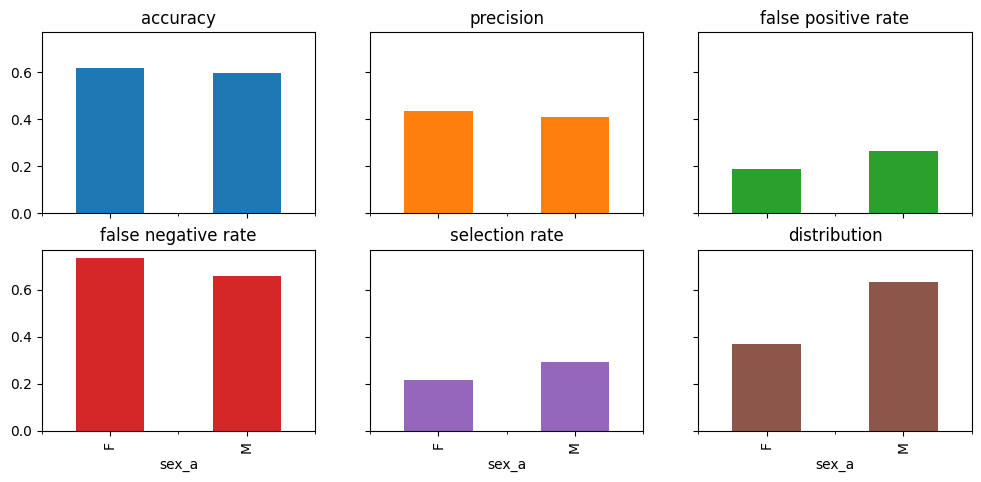

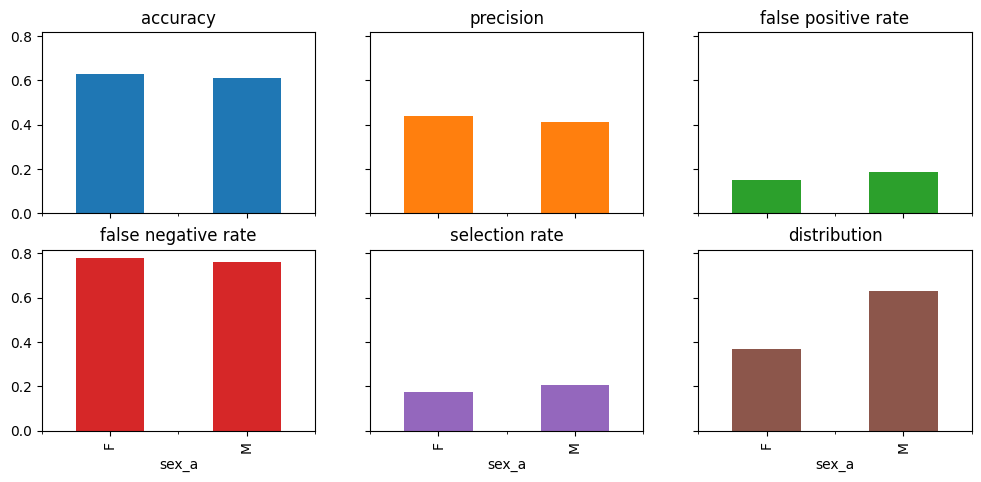

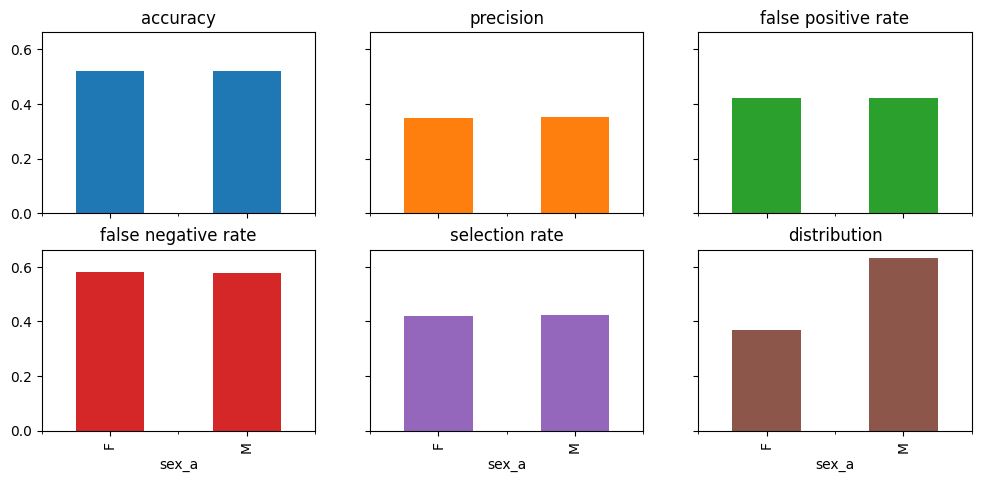

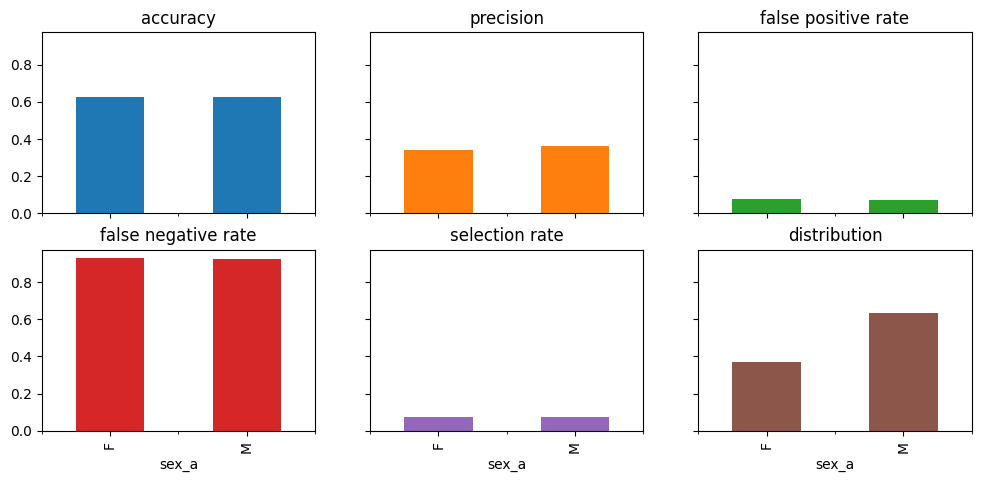

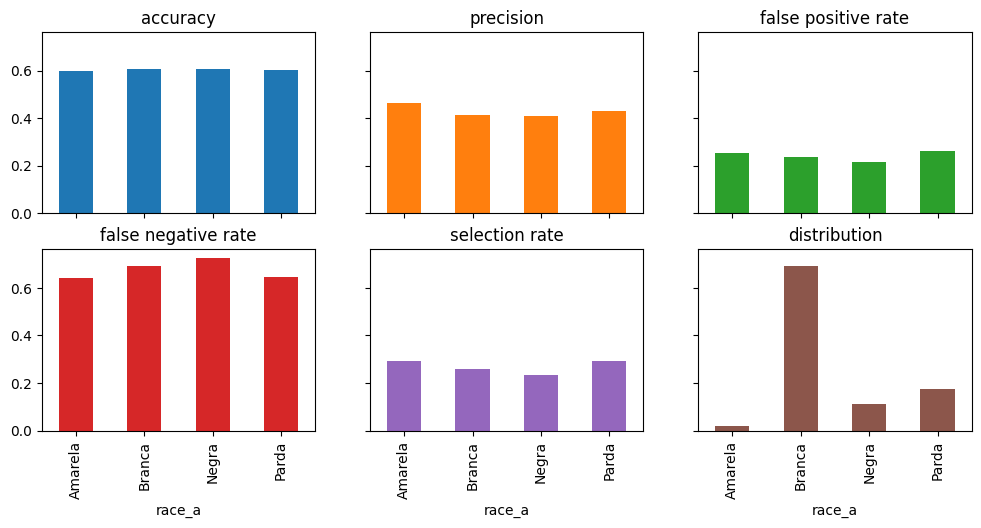

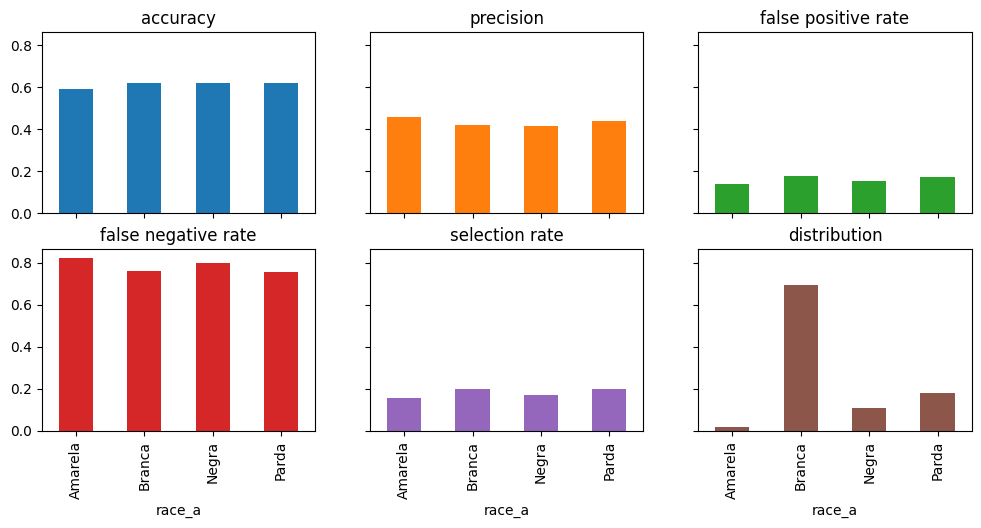

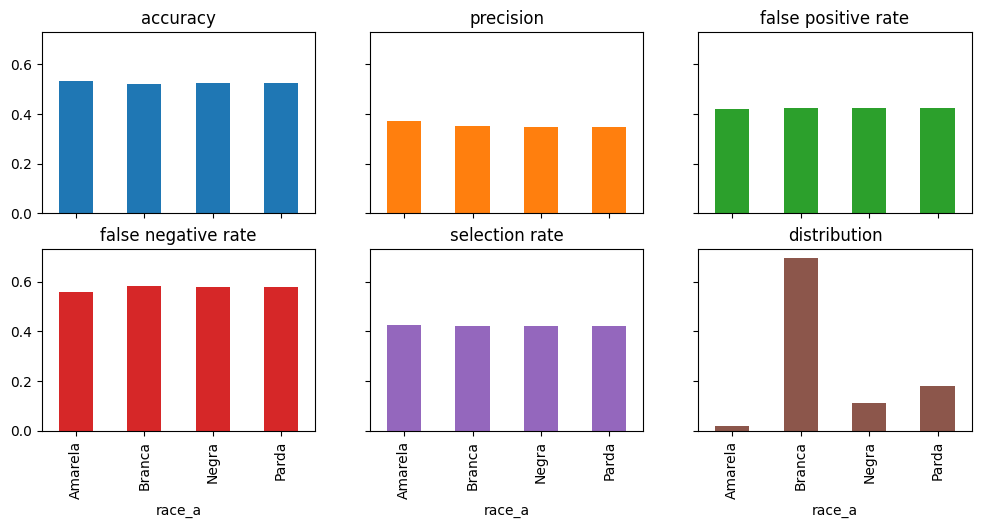

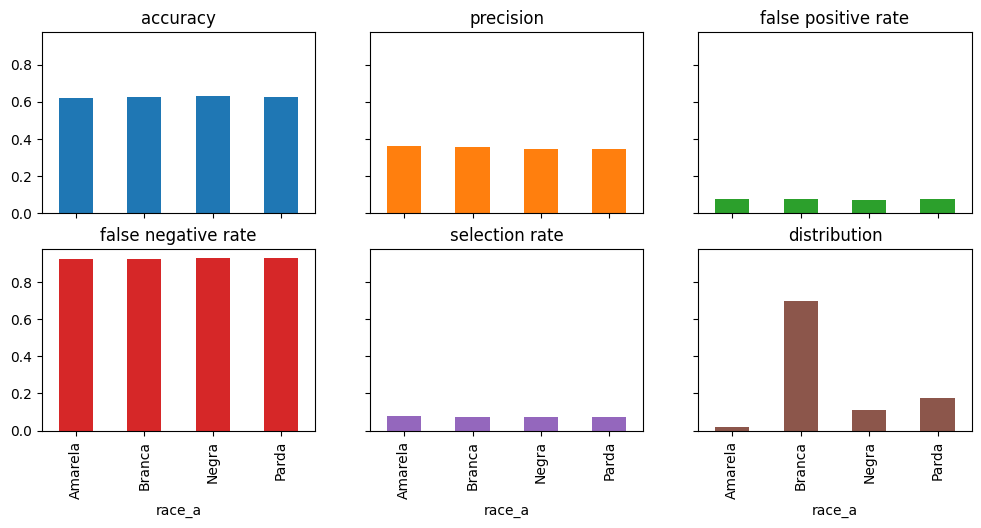

In [17]:
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate, selection_rate, count

def metric_frame(y_true, y_pred, sensitive):
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "distribution": lambda t, p: count(t, p) / y_true.shape[0]
    }
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        sharey=True
    )
    
metric_frame(y_test, y_pred > 0.5, df_pairs_test['sex_a'])
metric_frame(yu_test, yu_pred > 0.5, df_pairs_test_uncorrelated['sex_a'])
metric_frame(y_test, yf_pred > 0.5, df_pairs_test_uncorrelated['sex_a'])
metric_frame(y_test, yf2_pred > 0.5, df_pairs_test_uncorrelated['sex_a'])

metric_frame(y_test, y_pred > 0.5, df_pairs_test['race_a'])
metric_frame(yu_test, yu_pred > 0.5, df_pairs_test_uncorrelated['race_a'])
metric_frame(y_test, yf_pred > 0.5, df_pairs_test_uncorrelated['race_a'])
metric_frame(y_test, yf2_pred > 0.5, df_pairs_test_uncorrelated['race_a'])

In [18]:
# from aif360.sklearn.postprocessing import CalibratedEqualizedOdds
# import numpy as np
# postpros = CalibratedEqualizedOdds(['sex_a', 'race_a'], 'weighted', random_state=1729)
# postpros.fit(
#     X=pd.concat([meta[['sex_a', 'race_a']], pd.DataFrame(y_train_pred, columns=['p'])], axis=1).set_index(['sex_a', 'race_a']),
#     y=y
# )
# ypost_pred = postpros.predict_proba(pd.concat([meta_test['sex_a', 'race_a'], pd.DataFrame(y_pred, columns=['p'])]).set_index(['sex_a', 'race_a']))

In [19]:
# from aif360.sklearn.postprocessing import RejectOptionClassifierCV
# postpros2 = RejectOptionClassifierCV(['sex_a', 'race_a'], scoring='average_odds')
# postpros2.fit(
#     pd.concat([meta[['sex_a', 'race_a']], pd.DataFrame(y_train_pred, columns=['p'])], axis=1).set_index(['sex_a', 'race_a']),
#     y
# )
# ypost_pred2 = postpros2.predict_proba(
#     pd.concat([meta_test[['sex_a', 'race_a']], pd.DataFrame(y_pred, columns=['p'])], axis=1).set_index(['sex_a', 'race_a'])
# )

In [20]:
from fairlearn.postprocessing import ThresholdOptimizer

classifier = train_classifier(X,y)
postpros2 = ThresholdOptimizer(estimator=classifier,constraints='equalized_odds', flip=True, prefit=True)
postpros2.fit(X,y,sensitive_features=meta[protected_columns])
ypost_pred2 = postpros2.predict(X_test, sensitive_features=meta_test[protected_columns], random_state=1729)

In [21]:
print(f'threshold optimizer - acurácia: {accuracy_score(y_test, ypost_pred2)}, ROC AUC:{roc_auc_score(y_test, ypost_pred2)}')

threshold optimizer - acurácia: 0.604725, ROC AUC:0.537911556834413


In [22]:
group_privileged = (meta['sex_a'] == 'M') & (meta['race_a'] == 'Branca')
group_unprivileged = (meta['sex_a'] != 'M') | (meta['race_a'] != 'Branca')

In [23]:
from holisticai.bias.mitigation import CalibratedEqualizedOdds

y_tpred = classifier.predict_proba(X)

postpros3 = CalibratedEqualizedOdds(cost_constraint='weighted', alpha=0.5)
postpros3.fit(y,y_tpred, group_privileged, group_unprivileged)
ypost_pred3 = postpros3.transform(y_pred > 0.5, list(zip(1-y_pred, y_pred)), group_privileged, group_unprivileged)["y_pred"]

In [24]:
print(f'calibrated equalized odds - acurácia: {accuracy_score(y_test, ypost_pred3)}, ROC AUC:{roc_auc_score(y_test, ypost_pred3)}')

calibrated equalized odds - acurácia: 0.59909, ROC AUC:0.5387336374923675


In [25]:
from holisticai.bias.mitigation import LPDebiaserBinary

postpros = LPDebiaserBinary(constraint='EqualizedOdds')
postpros.fit(y,group_privileged, group_unprivileged, y_tpred > 0.5,y_tpred)
ypost_pred = postpros.transform(group_privileged, group_unprivileged, y_pred > 0.5, list(zip(1-y_pred, y_pred)))["y_pred"]

In [26]:
print(f'lpdebiaser binary - acurácia: {accuracy_score(y_test, ypost_pred)}, ROC AUC:{roc_auc_score(y_test, ypost_pred)}')

lpdebiaser binary - acurácia: 0.6447, ROC AUC:0.5117898553983374


In [27]:
from typing import Iterable
import numpy as np
from aif360.sklearn.metrics import theil_index

def absolute_avg_odds(X, y_true, y_pred) -> float:
    return abs(y_pred[(~X) & y_true].mean() - y_pred[X & y_true].mean()) / 2 + \
           abs(y_pred[(~X) & (~y_true)].mean() - y_pred[X & (~y_true)].mean()) / 2

def avg_predictive_value_difference(X, y_true, y_pred) -> float:
    return y_true[(~X) & y_pred].mean() - y_true[X & y_pred].mean() / 2 + \
           y_true[(~X) & (~y_pred)].mean() - y_true[X & (~y_pred)].mean() / 2

def get_benefit(y_true, y_pred) -> np.ndarray[int]:
    b = y_true.astype(int) + y_pred.astype(int)
    b = b.to_numpy()
    return np.piecewise(b, [b != 1, b == 1], [1, 0])


sex_privileged = df_pairs_test['sex_a'] == 'M'
race_privileged = df_pairs_test['race_a'] == 'Branca'

[
    f"{(ld, ly, 'abs_avg_odds:', absolute_avg_odds(d, t, p), 'theil:', theil_index(get_benefit(t,p)), 'acc:', accuracy_score(t,p))}"
    for (ld,d) in [('sex', sex_privileged), ('race', race_privileged)]
    for (ly, t, p) in [('baseline', y_test, y_pred > 0.5),
                       ('correlation remover', yu_test, yu_pred > 0.5), ('reweighted', y_test, yw_pred > 0.5),
                       ('exponentiated gradient', y_test, yf_pred > 0.5), ('grid search', y_test, yf2_pred > 0.5),
                       ('lp debiaser', y_test, ypost_pred), ('threshold optimizer', y_test, ypost_pred2),('calibrated eqodds', y_test, ypost_pred3),]
]

["('sex', 'baseline', 'abs_avg_odds:', 0.07632562885594558, 'theil:', 0.5029814697429417, 'acc:', 0.604725)",
 "('sex', 'correlation remover', 'abs_avg_odds:', 0.002853355370787694, 'theil:', 0.4812101888239008, 'acc:', 0.618035)",
 "('sex', 'reweighted', 'abs_avg_odds:', 0.0489075660715433, 'theil:', 0.5013457005668592, 'acc:', 0.605715)",
 "('sex', 'exponentiated gradient', 'abs_avg_odds:', 0.0023621936125217957, 'theil:', 0.6508638543052094, 'acc:', 0.521595)",
 "('sex', 'grid search', 'abs_avg_odds:', 0.0003258097043183916, 'theil:', 0.46738306592315404, 'acc:', 0.62664)",
 "('sex', 'lp debiaser', 'abs_avg_odds:', 0.007012019822315148, 'theil:', 0.4389701866655625, 'acc:', 0.6447)",
 "('sex', 'threshold optimizer', 'abs_avg_odds:', 0.07632562885594558, 'theil:', 0.5029814697429417, 'acc:', 0.604725)",
 "('sex', 'calibrated eqodds', 'abs_avg_odds:', 0.08174078062230777, 'theil:', 0.5123434417357888, 'acc:', 0.59909)",
 "('race', 'baseline', 'abs_avg_odds:', 0.013085788766918113, 'th